In [87]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from ucimlrepo import fetch_ucirepo
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, classification_report


## Phase 1: Business Understanding

- **The goal** is to reliably predict if website is a phishing site based on the information about the site using UCI Machine Learning Repository: Phishing Websites Data Set.

- **Requirements and Limits:**
    - ###### What we need:
        A model that can correctly identify phishing sites.
        The model should be easy to understand (especially the decision tree).

    - ###### Limits:
        We can only use the data provided in the dataset.
        The data may have some missing or incorrect information.
        The model should work fast if used in real-time situations.

    - ###### Expected Result:
        A decision tree model that shows clearly how decisions are made.
        A random forest model that predicts more accurately.


## Phase 2: Data understanding

- We use the Phishing dataset that is available at the UCI Machine Learning Repository.

- Value Types: int64, the dataset is suitable for analysis and machine learning models.
- Values: -1, 0, 1
  - 1: Indicates a phishing site
  - 1: Indicates a legitimate site
  - 0: Represents uncertain or ambiguous states. 

- There are no missing values, no any rows where all values are 0 or None.
- No unexpected values outside -1, 0, 1.
- nonsensical values: 0, 
    - 0 does not affect the outcome, we can adjust our approach to focus exclusively on distinguishing between phishing (-1) and legitimate (1) sites.

In [88]:
from ucimlrepo import fetch_ucirepo

# fetch dataset
phishing_websites = fetch_ucirepo(id=327)

# data (as pandas dataframes)
X = phishing_websites.data.features
y = phishing_websites.data.targets

print(phishing_websites.variables.name)

0              having_ip_address
1                     url_length
2             shortining_service
3               having_at_symbol
4       double_slash_redirecting
5                  prefix_suffix
6              having_sub_domain
7                 sslfinal_state
8     domain_registration_length
9                        favicon
10                          port
11                   https_token
12                   request_url
13                 url_of_anchor
14                 links_in_tags
15                           sfh
16           submitting_to_email
17                  abnormal_url
18                      redirect
19                  on_mouseover
20                    rightclick
21                   popupwindow
22                        iframe
23                 age_of_domain
24                     dnsrecord
25                   web_traffic
26                     page_rank
27                  google_index
28        links_pointing_to_page
29            statistical_report
30        

**Data understanding: check for variable's type.**

In [89]:
# Check data types of all columns
print(X.dtypes)

having_ip_address             int64
url_length                    int64
shortining_service            int64
having_at_symbol              int64
double_slash_redirecting      int64
prefix_suffix                 int64
having_sub_domain             int64
sslfinal_state                int64
domain_registration_length    int64
favicon                       int64
port                          int64
https_token                   int64
request_url                   int64
url_of_anchor                 int64
links_in_tags                 int64
sfh                           int64
submitting_to_email           int64
abnormal_url                  int64
redirect                      int64
on_mouseover                  int64
rightclick                    int64
popupwindow                   int64
iframe                        int64
age_of_domain                 int64
dnsrecord                     int64
web_traffic                   int64
page_rank                     int64
google_index                

**Data undestanding: check for the missing values.**

In [90]:
print(X.isnull().sum().sum())  # Total missing values

0


**Data understanding: check for rows where all values are 0 or None**

In [91]:
# Identify rows where all values are 0 or None

all_zero_rows = ((X == 0) | (X.isnull())).all(axis=1)

# Check if any such rows exist
if all_zero_rows.any():

    print(f"There are {all_zero_rows.sum()} rows where all values are 0.")
    
    # Display the indices of these rows
    print("Indices of rows with all zero values:", X[all_zero_rows].index.tolist())
else:
    print("No rows with all values equal to 0.")


No rows with all values equal to 0.


**Data undestanding: Check for unexpected values outside -1, 0, 1(outliers)**

In [92]:
# Check for unexpected values outside -1, 0, 1
invalid_values = X[~X.isin([-1, 0, 1]).all(axis=1)]

# Display rows with invalid data
print(invalid_values)


Empty DataFrame
Columns: [having_ip_address, url_length, shortining_service, having_at_symbol, double_slash_redirecting, prefix_suffix, having_sub_domain, sslfinal_state, domain_registration_length, favicon, port, https_token, request_url, url_of_anchor, links_in_tags, sfh, submitting_to_email, abnormal_url, redirect, on_mouseover, rightclick, popupwindow, iframe, age_of_domain, dnsrecord, web_traffic, page_rank, google_index, links_pointing_to_page, statistical_report]
Index: []

[0 rows x 30 columns]


## Phase 3: Data Preparation

The third phase is to preprocess the data. 

### Steps 

#### Cleaning the data,:

- There are no missing values, outliers, or nonsensical values. Therefore, we haven't done anything.

#### Feature Selection:
- By selecting relevant features, we improve model performance, reduce overfitting, and make the model easier to interpret.

We choose features based on what we know about the field or how important each feature is for predicting the target variable.

Using the selected feature list, we create a new dataframe with only these columns.

In [93]:
# Select important features
selected_features = [
    'url_length', 'shortining_service', 'having_at_symbol', 'double_slash_redirecting', 
    'prefix_suffix', 'having_sub_domain', 'sslfinal_state', 'abnormal_url', 'https_token', 'redirect', 'url_of_anchor', 'iframe', 'request_url', 'submitting_to_email'
]

#### Plitting the Data:

 To evaluate the model's performance on unseen data, we split the data into two subsets: 
    - Training data (80%) for training the model.
    - Test data (20%) for evaluating how well the model generalizes to new data.
    
  We use `train_test_split()` from scikit-learn to divide the data into training and test sets. 

In [94]:
# Create X with only selected features
X_selected = X[selected_features]

# Data Splitting
# Split the data: 80% training data, 20% testing data
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=42)

# Check the split sizes to ensure it's correct
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(8844, 14) (2211, 14) (8844, 1) (2211, 1)


We use `head()` to print the first few rows of the selected features dataset. Make sure everything looks correct before moving on to training.

In [95]:
print(X_selected.head())  # Print first few rows of the selected features dataset
feature_names = X_selected.columns.tolist()

   url_length  shortining_service  having_at_symbol  double_slash_redirecting  \
0           1                   1                 1                        -1   
1           1                   1                 1                         1   
2           0                   1                 1                         1   
3           0                   1                 1                         1   
4           0                  -1                 1                         1   

   prefix_suffix  having_sub_domain  sslfinal_state  abnormal_url  \
0             -1                 -1              -1            -1   
1             -1                  0               1             1   
2             -1                 -1              -1            -1   
3             -1                 -1              -1             1   
4             -1                  1               1             1   

   https_token  redirect  url_of_anchor  iframe  request_url  \
0           -1         0          

## Phase 4: Modeling
### PART 1

The chosen method is Decision Tree Classifier sklearn.tree. model = DecisionTreeClassifier(max_depth=4, random_state=42)

- max_depth=4: Limits the depth of the tree to 4 levels to prevent overfitting.
- random_state=42: Ensures reproducibility of the results by setting a seed for the random number generator. Number 42 was chosen because everyone knows that 42 is the answer to the ultimate question of life, the universe, and everything.
model.fit(X_train, y_train) The model is trained using the training data X_train and y_train.

plt.figure(figsize=(20,10)) plot_tree(model, feature_names=X_selected.columns, class_names=['Legit', 'Phishing'], filled=True) plt.show()

- A visual representation of the decision tree is created using plot_tree.
- feature_names=X_selected.columns: Names of the features used in the model.
- class_names=['Legit', 'Phishing']: Names of the target classes.
- filled=True: Colors the nodes to indicate the majority class.

y_pred = model.predict(X_test)

- Predictions are made on the test data X_test.

accuracy = accuracy_score(y_test, y_pred) conf_matrix = confusion_matrix(y_test, y_pred) precision = precision_score(y_test, y_pred) recall = recall_score(y_test, y_pred)

- accuracy_score: Measures the overall accuracy of the model.
- confusion_matrix: Provides a summary of prediction results.
- precision_score: Measures the precision of the model.
- recall_score: Measures the recall of the model.

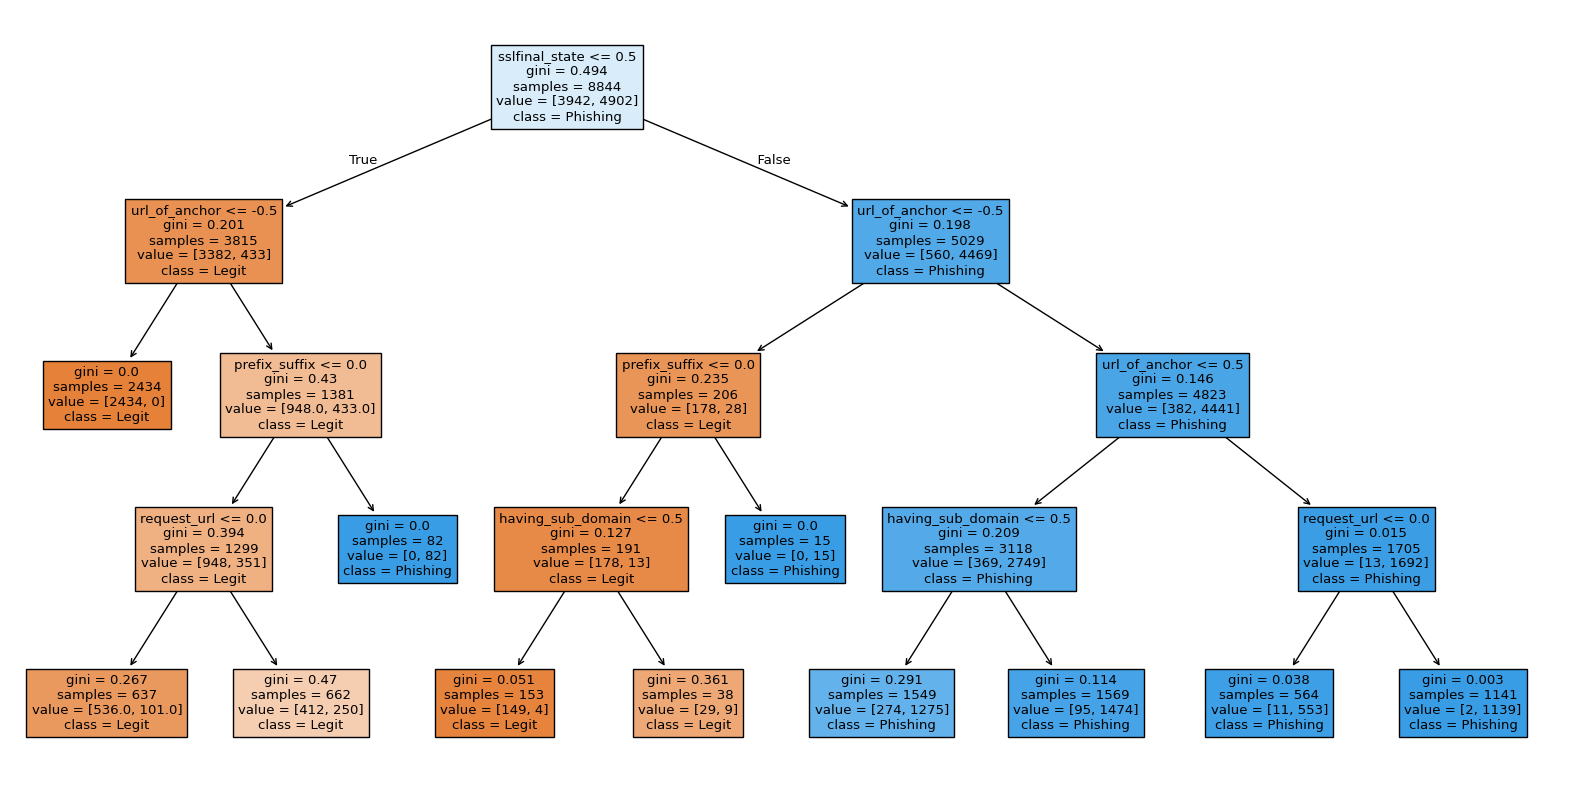

Accuracy: 0.9231117141564903
Confusion Matrix:
[[ 865   91]
 [  79 1176]]


In [96]:
from sklearn.tree import DecisionTreeClassifier, plot_tree

# Train a decision tree model
model = DecisionTreeClassifier(max_depth=4,random_state=42)
model.fit(X_train, y_train)

# Visualize the decision tree
plt.figure(figsize=(20,10))
plot_tree(model, feature_names=feature_names, class_names=['Legit', 'Phishing'], filled=True)
plt.show()

# Evaluate the decision tree
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

### PART 2
odel = RandomForestClassifier(random_state = 42, n_estimators = 100, max_features=0.75, max_samples=0.9, max_depth=10)

- random_state=42 – Similar to a Decision Tree, setting a random state ensures reproducibility. This means that every time we run this code with the same data, we will get the same results because the randomness in training is controlled.
- n_estimators=100 – This specifies the number of "trees" in our "forest." A Random Forest consists of multiple Decision Trees, each making its own predictions. The final classification is determined by majority voting among these trees.
- max_features=0.75 – This parameter controls how many features each tree can use when making decisions. By setting it to 0.75, each tree will only consider 75% of the total features, which helps to increase diversity among the trees and reduce overfitting by ensuring trees don’t rely on the same features.
- max_samples=0.9 – This determines what percentage of the training data each tree is trained on. With this setting, each tree is trained on a randomly selected 90% of the training data. Since each tree is trained on different subsets of data, this further increases diversity and helps the model generalize better.
- max_depth=10 – This limits the depth of each individual tree to 10 levels. Unlike in a single Decision Tree, where limiting depth is crucial to prevent overfitting, Random Forests naturally reduce overfitting through ensembling. However, setting a max_depth can still be useful for computational efficiency and to further control complexity.

model.fit(X_train, y_train.values.ravel())

.values - convertes the datafames pandas to numby format. .ravel - flattens 2D array to 1D

These needed to be done to correctly format y_train to this sklearn model.

for i in range(3): plt.figure(figsize=(20, 10)) plot_tree(model.estimators_[i], filled=True, feature_names=feature_names, class_names=['Legit', 'Phishing'], max_depth=5) plt.title(f'Random Forest - Tree {i+1}') plt.show()

for i in range(3): Gives a view of multiple trees in the forest to understand their individual decision-making processes. In this case three of the first trees are visualised.

plt.figure(figsize=(20, 10)) Sets up a figure for the visuals. It makes the visual tree large enough to clearly see the structure, since decision trees can get complex, especially with deeper levels.

plot_tree(model.estimators_[i], filled=True, feature_names=feature_names, class_names=['Legit', 'Phishing'], max_depth=5)

- model.estimators_[i] - Selects the i-th tree in the Random Forest model.
- filled=True - Colors the nodes to indicate the majority class.
- feature_names=feature_names - Names of the features used in the model.
- class_names=['Legit', 'Phishing'] - shows the predicted class at each leaf of the tree.
- max_depth=4 - limits the visualization to 4 levels of the tree to fasten the loading.

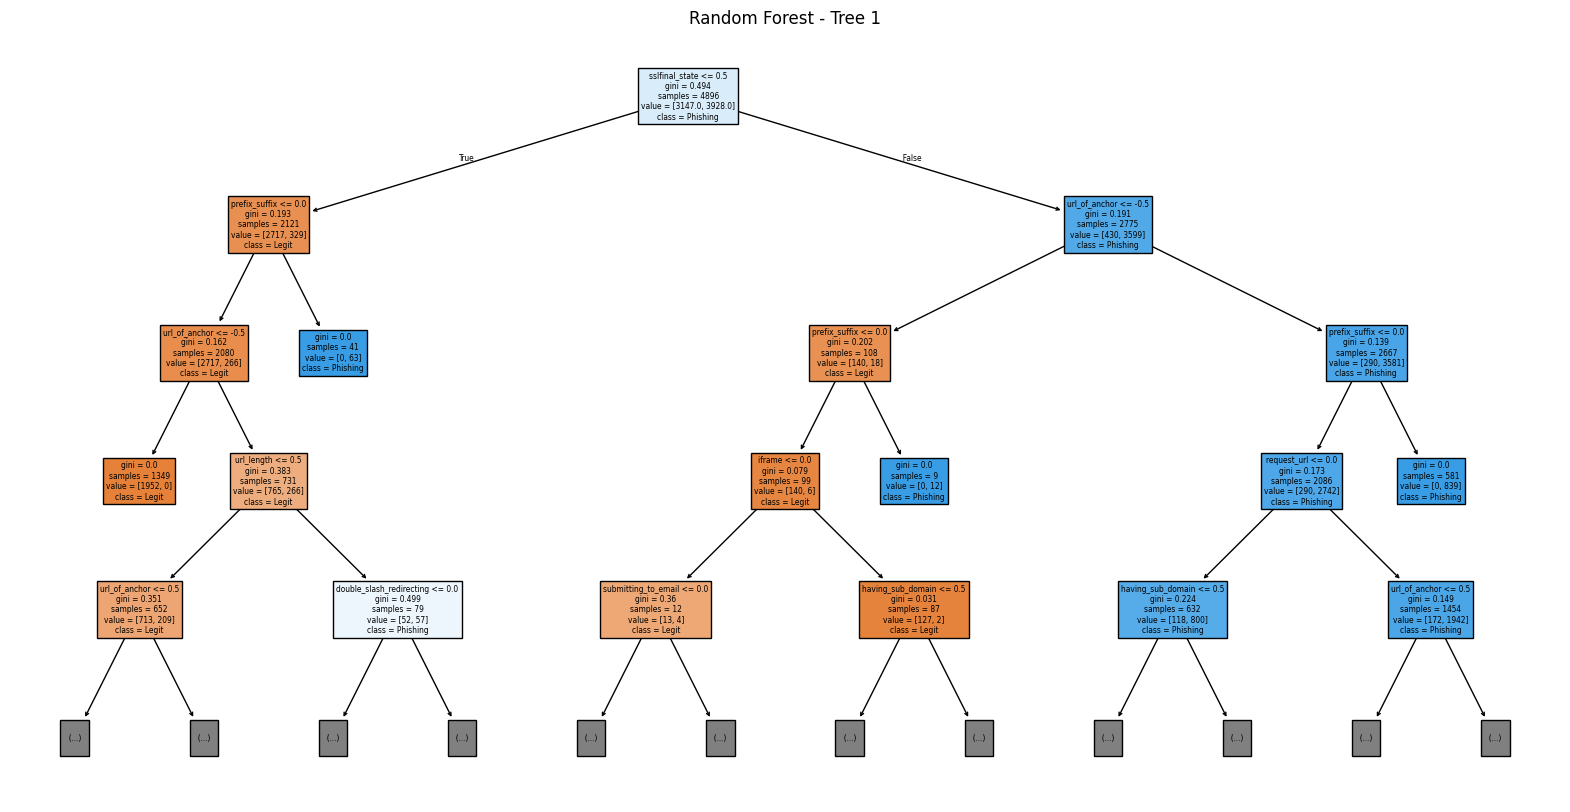

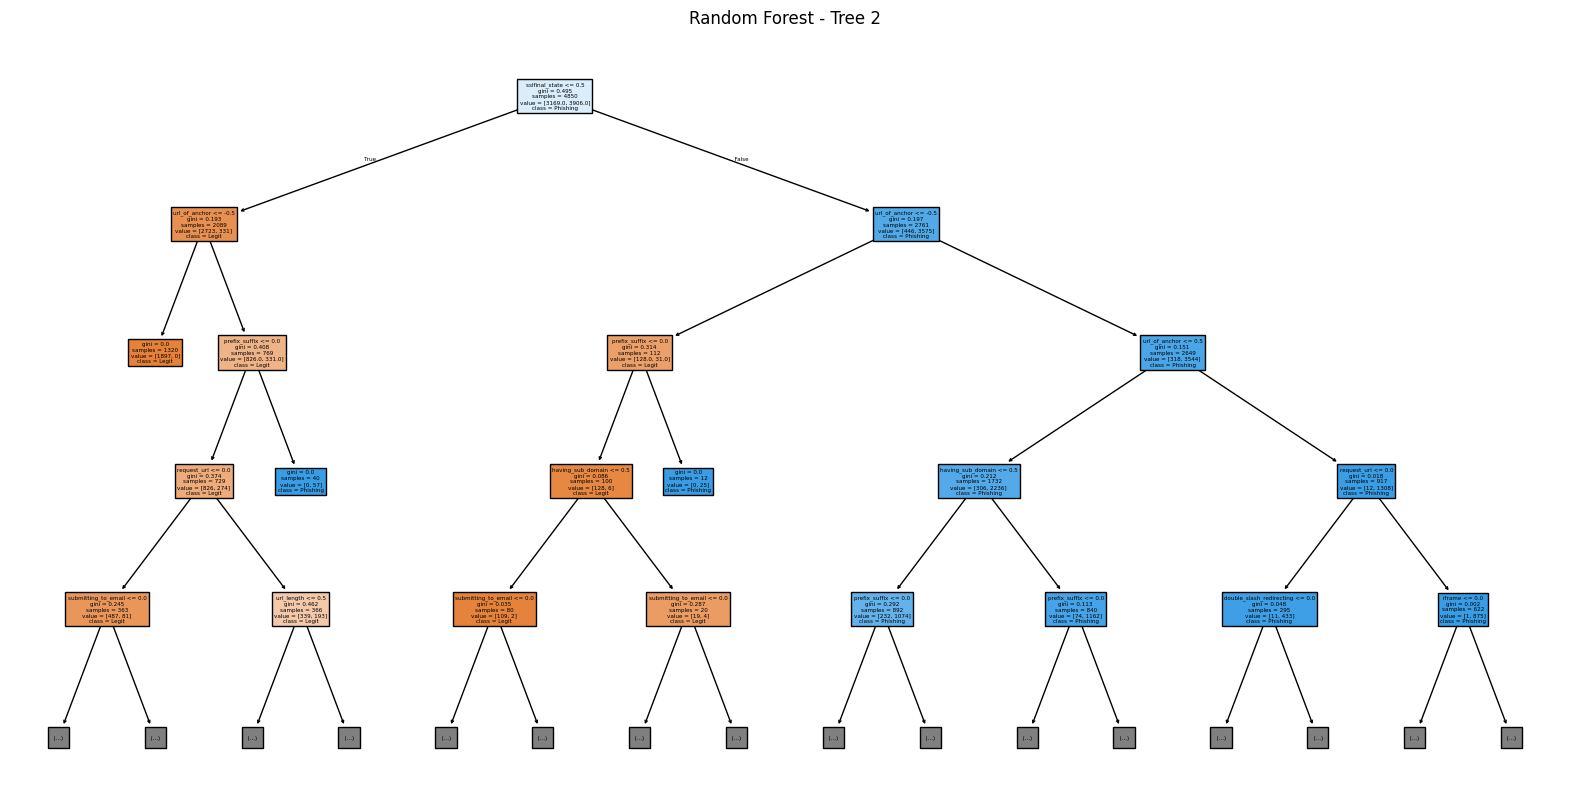

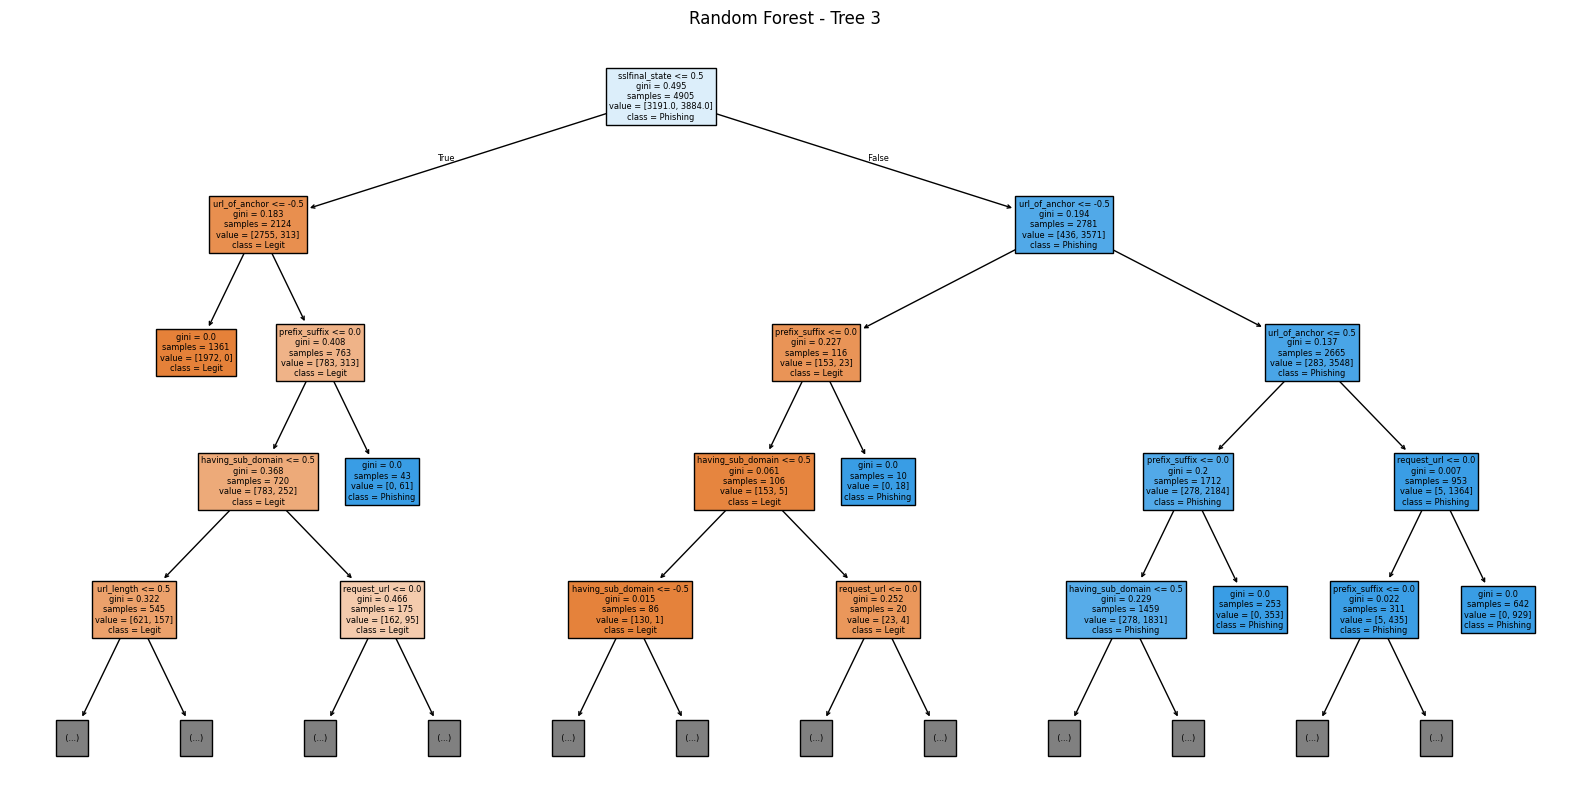

Accuracy: 0.9380370872908186
Confusion Matrix:
[[ 865   91]
 [  46 1209]]


In [97]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(random_state = 42, n_estimators = 100,
                               max_features=0.75, max_samples=0.8, max_depth=10)
model.fit(X_train, y_train.values.ravel())

for i in range(3):
    plt.figure(figsize=(20, 10))
    plot_tree(model.estimators_[i], filled=True, feature_names=feature_names,
              class_names=['Legit', 'Phishing'], max_depth=4)
    plt.title(f'Random Forest - Tree {i+1}')
    plt.show()

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f'Accuracy: {accuracy}')
print(f'Confusion Matrix:\n{conf_matrix}')

## Phase 5: Evaluation

In [99]:
# Evaluate the Decision Tree Model
print("Decision Tree Model Evaluation:")

# Format Confusion Matrix for Decision Tree
conf_matrix_df = pd.DataFrame(
    conf_matrix,
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"]
)
print("Confusion Matrix:")
print(conf_matrix_df.to_string())
print(f'\nAccuracy: {accuracy_score(y_test, y_pred):.4f}')
print(f'Precision: {precision_score(y_test, y_pred):.4f}')
print(f'Recall: {recall_score(y_test, y_pred):.4f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Evaluate the Random Forest Model
print("\nRandom Forest Model Evaluation:")

# Generate predictions
y_pred_rf = model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
precision_rf = precision_score(y_test, y_pred_rf)
recall_rf = recall_score(y_test, y_pred_rf)

# Format Confusion Matrix for Random Forest
conf_matrix_rf_df = pd.DataFrame(
    conf_matrix_rf,
    index=["Actual Negative", "Actual Positive"],
    columns=["Predicted Negative", "Predicted Positive"]
)
print("Confusion Matrix:")
print(conf_matrix_rf_df.to_string())
print(f'\nAccuracy: {accuracy_rf:.4f}')
print(f'Precision: {precision_rf:.4f}')
print(f'Recall: {recall_rf:.4f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred_rf))

Decision Tree Model Evaluation:
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 865                  91
Actual Positive                  46                1209

Accuracy: 0.9380
Precision: 0.9300
Recall: 0.9633

Classification Report:
              precision    recall  f1-score   support

          -1       0.95      0.90      0.93       956
           1       0.93      0.96      0.95      1255

    accuracy                           0.94      2211
   macro avg       0.94      0.93      0.94      2211
weighted avg       0.94      0.94      0.94      2211


Random Forest Model Evaluation:
Confusion Matrix:
                 Predicted Negative  Predicted Positive
Actual Negative                 865                  91
Actual Positive                  46                1209

Accuracy: 0.9380
Precision: 0.9300
Recall: 0.9633

Classification Report:
              precision    recall  f1-score   support

          -1       0.95      0.

While the decision tree is simple, easy to interpret, and effective, it misclassifies a moderate number of phishing websites as legitimate and vice versa.

The random forest model improves accuracy and significantly reduces the number of false negatives (phishing websites incorrectly classified as legitimate). This aligns better with the business goal of reliably protecting users from phishing sites.

## Phase 6: Deployment
### Real-World Use
#### Automated Warning System:
- Integrate the Random Forest model into a browser extension or security software.
- The model flags phishing websites in real time based on their features.
#### Monitoring and Updates:
- Periodically retrain the model with new data to adapt to evolving phishing techniques.
### Communication of Results
#### For Technical Teams:
- Provide the model's evaluation metrics (accuracy, precision, recall) along with code and instructions for integration.
- Explain feature importance for easier debugging and updates.
#### For End Users:
- Display warnings like "This website might be a phishing site. Proceed with caution."
- Include educational information about phishing.
### Steps for Deployment
#### Integration:
- The trained Random Forest model is saved using pickle.
- Deploy the model as a REST API or embed it into client-side software.
#### Scaling:
- Use cloud platforms like AWS or Azure for handling large-scale predictions.
#### Testing:
- Run extensive tests on live data to ensure consistent performance.
### Model Limitations
- Predictions depend solely on the features available in the dataset.
- If phishing techniques evolve significantly, the model may need retraining.

In [100]:
# Phase 6: Deployment
# Deploy the model. How will the model be used in practice? How will the results be communicated?

# Save the model for deployment (Decision Tree)
import pickle

# Save Decision Tree model to file
with open('decision_tree_model.pkl', 'wb') as file:
    pickle.dump(model, file)

# Save Random Forest model to file
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(model, file)

print("Models saved successfully for deployment!")

Models saved successfully for deployment!
